In [1]:
import findspark
findspark.init()

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, mean, sum, stddev, count, lit, when
from pyspark.sql.window import Window
import pyspark.sql.functions as F

from pyspark.sql.functions import col, isnan, when, count

In [3]:
spark = SparkSession.builder \
    .appName("PySpark Interview Sample DataFrame") \
    .getOrCreate()
spark

In [4]:
data_e = spark.read.csv(r"C:\Users\Shrey Kumar Soni\Downloads\archive (6)\election_results_2024.csv", header = True, inferSchema = True)
data_e.show()

+----------------+----------+--------------------+--------------------+--------------------+--------------------+------+---------------+
|    Constituency|Const. No.|   Leading Candidate|       Leading Party|  Trailing Candidate|      Trailing Party|Margin|         Status|
+----------------+----------+--------------------+--------------------+--------------------+--------------------+------+---------------+
|           AJMER|        13| BHAGIRATH CHOUDHARY|Bharatiya Janata ...|RAMCHANDRA CHOUDHARY|Indian National C...|329991|Result Declared|
|           ALWAR|         8|     BHUPENDER YADAV|Bharatiya Janata ...|         LALIT YADAV|Indian National C...| 48282|Result Declared|
|          AMBALA|         1|      VARUN CHAUDHRY|Indian National C...|       BANTO KATARIA|Bharatiya Janata ...| 49036|Result Declared|
|ANANTNAG-RAJOURI|         3|    MIAN ALTAF AHMAD|Jammu & Kashmir N...|      MEHBOOBA MUFTI|Jammu & Kashmir P...|281794|Result Declared|
|       ARAKKONAM|         7|   S JAGATHR

**schema understanding**

In [25]:
data_e.printSchema()

root
 |-- Constituency: string (nullable = true)
 |-- Const. No.: integer (nullable = true)
 |-- Leading Candidate: string (nullable = true)
 |-- Leading Party: string (nullable = true)
 |-- Trailing Candidate: string (nullable = true)
 |-- Trailing Party: string (nullable = true)
 |-- Margin: string (nullable = true)
 |-- Status: string (nullable = true)



**statistics**

In [26]:
data_e.describe().show()

+-------+------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|summary|Constituency|        Const. No.|   Leading Candidate|       Leading Party|  Trailing Candidate|      Trailing Party|            Margin|         Status|
+-------+------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|  count|         543|               543|                 543|                 543|                 542|                 542|               543|            543|
|   mean|        null| 18.17863720073665|                null|                null|                null|                null|162350.08302583024|           null|
| stddev|        null|16.427840209008284|                null|                null|                null|                null|147262.75172945217|           null|
|    min|       AJMER|            

**Count Missing Values**

In [38]:
for i in data_e.columns:
    # Correctly handle column names with special characters or spaces
    missing_values_df = data_e.filter(col(f"`{i}`").isNull())
    print(i, missing_values_df.count())

Constituency 0
Const. No. 0
Leading Candidate 0
Leading Party 0
Trailing Candidate 1
Trailing Party 1
Margin 0
Status 0


##### **Differentiate between numerical and categorical data**
  - **Get all columns and their data types.**
  - **Filter out initial numerical columns based on data type.**
  - **For each column with data type 'string':**
    - **Attempt to cast the column to float.**
    - **Count the number of non-null entries after the cast.**
    - **If a significant portion of the column can be cast (e.g., more than 95%), consider it numerical.**
    - **Otherwise, consider it categorical.**


In [47]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Step 1: List all columns and their data types
data_types = dict(data_e.dtypes)

# Step 2: Identify initial numerical columns
numerical_columns = [column for column, dtype in data_types.items() if dtype in ['int', 'float', 'double']]

# Placeholder for categorical columns
categorical_columns = []

# Step 3: Attempt to cast string columns to numerical
for column, dtype in data_types.items():
    if dtype == 'string':
        # Attempt to cast the column to FloatType
        casted_column = data_e.withColumn(column, col(column).cast(FloatType()))
        
        # Count non-null entries after casting
        non_null_count = casted_column.filter(col(column).isNotNull()).count()
        
        # If a significant portion can be cast, consider it numerical
        if non_null_count / data_e.count() > 0.95:  # Adjust the threshold as needed
            numerical_columns.append(column)
        else:
            categorical_columns.append(column)

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: ['Const. No.', 'Margin']
Categorical Columns: ['Constituency', 'Leading Candidate', 'Leading Party', 'Trailing Candidate', 'Trailing Party', 'Status']


**Unique Values in Categorical Columns**
- **only show distinct count values are less than 50**

In [54]:
from pyspark.sql.functions import col

for column in categorical_columns:  
    distinct_count = data_e.select(column).distinct().count()
    if distinct_count > 50:
        print(f"{column} has more than 50 distinct values.")
    else:
        distinct_values = data_e.select(column).distinct().collect()
        distinct_values_list = [row[column] for row in distinct_values]
        print(f"{column} distinct values: {distinct_values_list}")

Constituency has more than 50 distinct values.
Leading Candidate has more than 50 distinct values.
Leading Party distinct values: ['Nationalist Congress Party', 'Voice of the People Party', 'All India Trinamool Congress', 'Jharkhand Mukti Morcha', 'Aam Aadmi Party', 'Viduthalai Chiruthaigal Katch', 'Apna Dal (Soneylal)', 'Lok Janshakti Party(Ram Vilas)', 'Nationalist Congress Party – Sharadchandra Pawar', 'Rashtriya Loktantrik Party', 'Shiv Sena (Uddhav Balasaheb Thackrey)', 'Janata Dal (Secular)', 'Janata Dal (United)', 'Indian National Congress', 'Bharat Adivasi Party', 'Sikkim Krantikari Morcha', 'Shiv Sena', 'Kerala Congress', 'Communist Party of India (Marxist)', 'Hindustani Awam Morcha (Secular)', 'Shiromani Akali Dal', 'Yuvajana Sramika Rythu Congress Party', 'Janasena Party', 'Rashtriya Janata Dal', 'AJSU Party', 'Jammu & Kashmir National Conference', 'Revolutionary Socialist Party', 'Aazad Samaj Party (Kanshi Ram)', 'Bharatiya Janata Party', 'Indian Union Muslim League', 'Rash

**Correlation Analysis**

**Cramér's V is a statistical measure used to assess the strength and significance of the association between two nominal (categorical) variables. It ranges from 0 (no association) to 1 (perfect association). This measure is based on the chi-squared statistic from a contingency table of the variables involved. Cramér's V is particularly useful for analyzing categorical data where Pearson's correlation coefficient is not applicable.**

In [63]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Initialize Spark session
spark = SparkSession.builder.appName("Lok Sabha Analysis").getOrCreate()

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    # Adding a small epsilon value to avoid division by zero
    epsilon = 1e-10
    return np.sqrt(phi2corr / max(min((kcorr-1), (rcorr-1)), epsilon))

# Assuming data_e is a Spark DataFrame loaded previously
# Example: data_e = spark.read.csv("path_to_your_data.csv", header=True, inferSchema=True)

try:
    # Create a copy of data_e for manipulation
    data_e_copy = data_e

    # Correctly rename the column without using backticks in the string
    data_e_copy = data_e_copy.withColumnRenamed("Const. No.", "Const_No")

    # Assuming categorical_columns is a list of your categorical column names
    # Example: categorical_columns = ['column1', 'column2']

    # Fill missing values in categorical columns with 'Unknown'
    for column in categorical_columns:
        data_e_copy = data_e_copy.fillna({column: 'Unknown'})

    # Attempt to convert to pandas DataFrame for correlation analysis
    data_e_pd = data_e_copy.select(categorical_columns).toPandas()

    # Initialize an empty DataFrame to store Cramér's V values
    cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

    # Calculate Cramér's V for each pair of variables
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                # The correlation of a variable with itself is 1
                cramers_v_matrix.at[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(data_e_pd[col1], data_e_pd[col2])
                cramers_v_matrix.at[col1, col2] = cramers_v(confusion_matrix)

    print(cramers_v_matrix)
except Exception as e:
    print(f"An error occurred: {e}")

                    Constituency  Leading Candidate  ...  Trailing Party    Status
Constituency            1.000000           0.000000  ...        0.000000  0.060802
Leading Candidate       0.000000           1.000000  ...        0.000000  0.042993
Leading Party           0.000000           0.275292  ...        0.457716  0.000000
Trailing Candidate      0.000000           0.000000  ...        0.000000  0.000000
Trailing Party          0.000000           0.000000  ...        1.000000  0.961361
Status                  0.060802           0.042993  ...        0.961361  1.000000

[6 rows x 6 columns]


#### **Data Visualization**
**based on data understanding**

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Convert to Pandas DataFrame for visualization (use with caution for large datasets)
pandas_df = data_e.sample(fraction=0.1).toPandas()  # Adjust fraction as needed

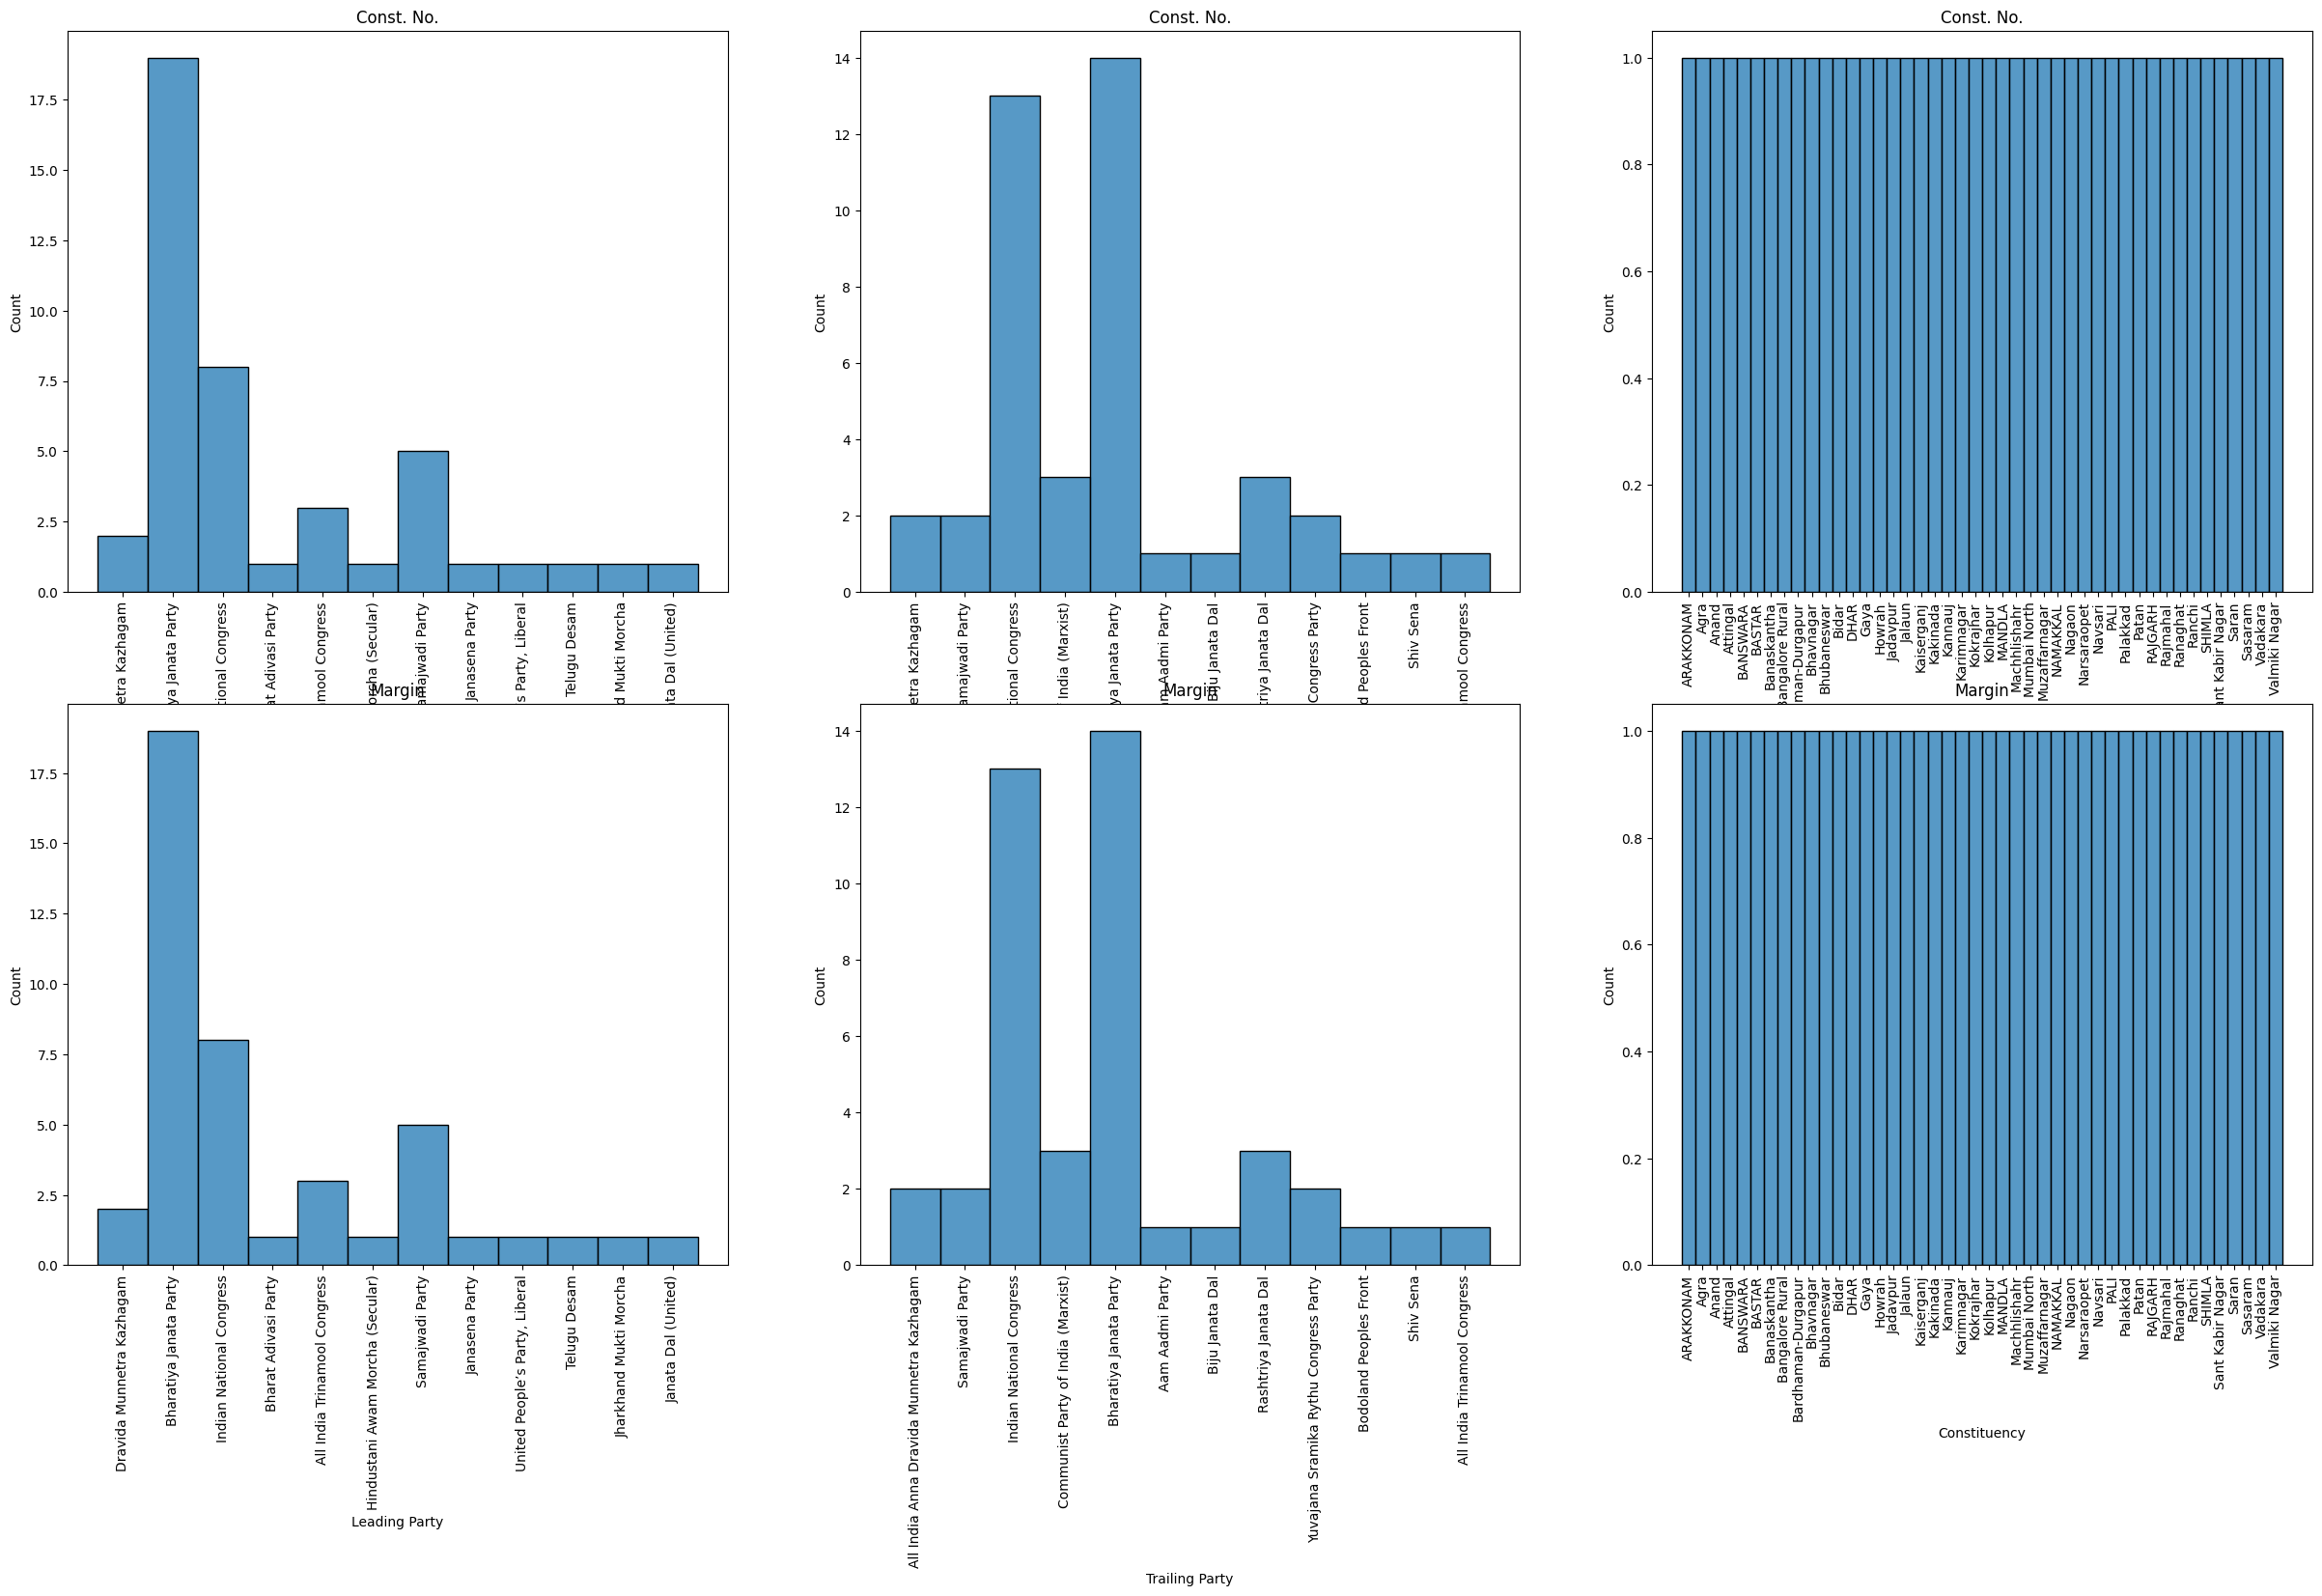

In [93]:
a = 9  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
plot_columns = ["Leading Party", "Trailing Party", "Constituency" ]
fig = plt.figure(figsize=(30,80))

for i in numerical_columns:
    for j in plot_columns:
        plt.subplot(a, b, c)
        plt.title('{}'.format(i))

        sns.histplot(data= pandas_df, x= j)
        
        plt.xticks(rotation = 90)

        c = c + 1

plt.show()

In [102]:
from pyspark.sql import functions as F

# Assuming 'data_e' is your DataFrame
data = data_e.groupBy("Constituency", "Leading Party", "Trailing Party")\
             .agg(F.count("Status").alias("Status_Count"))

data.show()

+---------------+--------------------+--------------------+------------+
|   Constituency|       Leading Party|      Trailing Party|Status_Count|
+---------------+--------------------+--------------------+------------+
|           Agra|Bharatiya Janata ...|     Samajwadi Party|           1|
|     Aurangabad|           Shiv Sena|All India Majlis-...|           1|
|    Banaskantha|Indian National C...|Bharatiya Janata ...|           1|
|      FARIDABAD|Bharatiya Janata ...|Indian National C...|           1|
|         Nashik|Shiv Sena (Uddhav...|           Shiv Sena|           1|
|       Amritsar|Indian National C...|     Aam Aadmi Party|           1|
|      Sambalpur|Bharatiya Janata ...|     Biju Janata Dal|           1|
|     Araku (ST)|Yuvajana Sramika ...|Bharatiya Janata ...|           1|
|Bangalore Rural|Bharatiya Janata ...|Indian National C...|           1|
|        Barasat|All India Trinamo...|Bharatiya Janata ...|           1|
|         Jalaun|     Samajwadi Party|Bharatiya Jan

In [24]:
sum_margin_df = data_e.groupBy("Constituency", "Leading Party").agg(
    F.sum("Margin").alias("Sum of Margin"),
    F.count("Trailing Party").alias("Count of Trailing Party"),
    F.count("Leading Party").alias("Count of Leading Party")
)

# Show the result
sum_margin_df.show()
# Show the result
sum_margin_df.show()

+-------------+--------------------+-------------+-----------------------+----------------------+
| Constituency|       Leading Party|Sum of Margin|Count of Trailing Party|Count of Leading Party|
+-------------+--------------------+-------------+-----------------------+----------------------+
|  Lakshadweep|Indian National C...|       2647.0|                      1|                     1|
|Chandni Chowk|Bharatiya Janata ...|      89325.0|                      1|                     1|
|     Fatehpur|     Samajwadi Party|      33199.0|                      1|                     1|
|       Ghatal|All India Trinamo...|     182868.0|                      1|                     1|
|      Palamau|Bharatiya Janata ...|     288807.0|                      1|                     1|
|    Baharaich|Bharatiya Janata ...|      64227.0|                      1|                     1|
|  Gandhinagar|Bharatiya Janata ...|     744716.0|                      1|                     1|
| KANCHEEPURAM|Dravi

In [15]:
sum_margin_df = data_e.groupBy("Constituency", "Leading Party").agg(F.sum("Margin").alias("Sum of Margin"))

# Show the result
sum_margin_df.show()

+-------------+--------------------+-------------+
| Constituency|       Leading Party|Sum of Margin|
+-------------+--------------------+-------------+
|  Lakshadweep|Indian National C...|       2647.0|
|Chandni Chowk|Bharatiya Janata ...|      89325.0|
|     Fatehpur|     Samajwadi Party|      33199.0|
|       Ghatal|All India Trinamo...|     182868.0|
|      Palamau|Bharatiya Janata ...|     288807.0|
|    Baharaich|Bharatiya Janata ...|      64227.0|
|  Gandhinagar|Bharatiya Janata ...|     744716.0|
| KANCHEEPURAM|Dravida Munnetra ...|     221473.0|
|        Ghosi|     Samajwadi Party|     162943.0|
|Muzaffarnagar|     Samajwadi Party|      24672.0|
|    CUDDALORE|Indian National C...|     185896.0|
|    Jalandhar|Indian National C...|     175993.0|
|       Munger| Janata Dal (United)|      80870.0|
|     Rajampet|Yuvajana Sramika ...|      76071.0|
|  Jhanjharpur| Janata Dal (United)|     184169.0|
|      Karakat|Communist Party o...|     105858.0|
|    Nandurbar|Indian National 

In [103]:
spark.stop()